### 代码示例

以2016年北京地铁西直门站每15min客流的进站数据为例，利用PyTorch搭建一维卷积神经网络，实现对进站客流数据的预测。

1. 导包

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from numpy.lib.stride_tricks import sliding_window_view

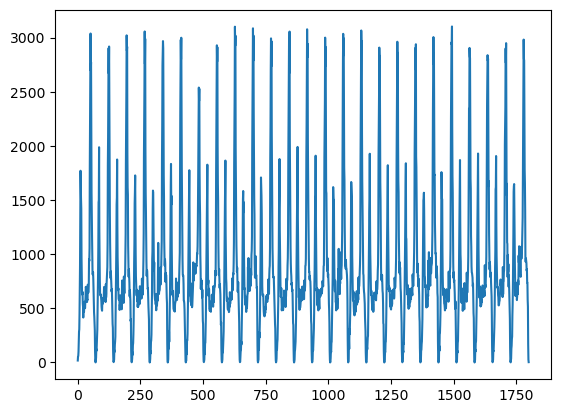

In [2]:
path = './卷积神经网络/15min_in.csv'
df = pd.read_csv(path, encoding='gbk', parse_dates=True)
data = df['西直门'].values.astype('float32')

plt.plot(data)
plt.show()

2. 拆分数据集

In [3]:
print(len(data))
split_num = 300
train = data[:-split_num]
test = data[-split_num:]

1800


3. 归一化，按时间窗初始化数据

In [4]:
'''
归一化
'''
scaler = MinMaxScaler(feature_range=(-1,1))
train_norm = scaler.fit_transform(train.reshape(-1,1))
test_norm = scaler.fit_transform(test.reshape(-1,1))
# 转tensor并摊开
train_set = torch.FloatTensor(train_norm).view(-1)
test_set = torch.FloatTensor(test_norm).view(-1)
'''
样本提取（时间窗）
从原时间序列中抽取出训练样本，用第1个值到第72个值作为X输入，预测第73个值作为y输出
'''
Time_window_size = 72
def input_data(seq, ws):  
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i + ws]
        label = seq[i + ws:i + ws + 1]
        out.append((window, label))
    return out
train_data = input_data(train_set, Time_window_size)
test_data = input_data(test_set, Time_window_size)

4. 模型搭建

In [5]:
'''
模型搭建
'''
class CNN_NETWORK(nn.Module):
    def __init__(self):
        super(CNN_NETWORK,self).__init__()
        # 使用64个卷积核，大小为2，在一维序列上进行一维卷积
        self.conv1d = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=2)
        # 激活函数：为卷积输出引入非线性
        self.relu = nn.ReLU(inplace=True)
        # 使用32个卷积核，大小为2，在64维序列上进行一维卷积
        self.conv1d2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=2)
        # 一维最大池化层，窗口大小 2、步幅 2，将时序长度缩减一半，突出最显著特征并降低计算量。
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32*35, 640)
        self.fc2 = nn.Linear(640, 1)
        # Dropout 层，训练时随机丢弃 50% 的神经元，防止过拟合。
        self.drop = nn.Dropout(0.5)
    
    def forward(self,x):
        '''
        x [1,1,72] -> [1,64,71]
        input N(batch) Cin(seq) Lin(size) 
        '''
        x = self.conv1d(x) 
        # 激活函数，shape不变
        x = self.relu(x)
        '''
        x [1,64,71] -> [1,32,70]
        '''
        x = self.conv1d2(x)
        x = self.relu(x)
        '''
        x [1,32,70] -> [1,32,35]
        '''
        x = self.pool(x)
        x = self.drop(x)
        '''
        x [1,32,35] -> [1120]
        '''
        x = x.view(-1)
        '''
        x [1120] -> 640
        '''
        x = self.fc1(x)
        x = self.relu(x)
        '''
        x [1120] -> 640
        '''
        x = self.fc2(x)
        return x

device = torch.device("cuda")
net = CNN_NETWORK().to(device)
print(device)

cuda


5. 模型训练

In [6]:
'''
模型训练
'''
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0005)

epoch = 2

for e in range(epoch):
    for seq, y_train in train_data:
        optimizer.zero_grad()
        y_train = y_train.to(device)
        seq = seq.reshape(1,1,-1).to(device)
        y_pre = net(seq)
        loss_val = criterion(y_pre,y_train)
        loss_val.backward()
        optimizer.step()
    print(f'epoch:{e},loss:{loss_val}')

epoch:0,loss:0.00025611836463212967
epoch:1,loss:0.03752532973885536


6. 画图

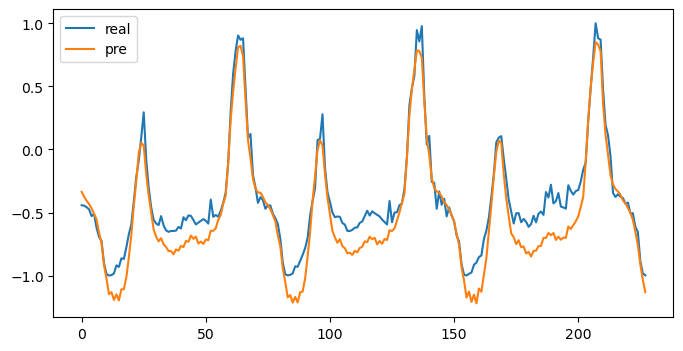

In [12]:
test_seq = torch.FloatTensor(test)
realVal = []
preVal = []
with torch.no_grad():
    net.eval()

    for seq, y_test in test_data:
        seq = seq.reshape(1, 1, -1).to(device)
        test_pre = net(seq)
        realVal.append(y_test.numpy())
        # 注意要把cuda变量扔回cpu
        preVal.append(test_pre.cpu().numpy())

plt.figure(figsize=(8,4))
plt.plot(realVal, label='real')
plt.plot(preVal, label='pre')
plt.legend()
plt.show()